<a href="https://colab.research.google.com/github/SisekoC/My-Notebooks/blob/main/few_shot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Few-Shot learning z Reptile
##Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import urllib3

##Hyperparameters

In [2]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

##Data preparation

In [4]:
class Dataset:
  # The class will facilitate the creation of a few-shot collection from the Omniglot collection, from which you can
  # take samples and make it possible to create new labels at the same time.
  def __init__(self, training):
    # Downloading tfrecord files containing omniglot data and converting the data
    split = 'train' if training else 'test'
    ds = tfds.load('omniglot', split=split, as_supervised=True, shuffle_files=False)
    # Iterate through the collection to get each individual image and its class
    # and insert this data into the dictionary.
    self.data = {}

    def extraction(img, label):
      # The function shrinks Omniglot images to the desired size,
      # scales the pixel values and converts the RGB image to gray
      img = tf.image.convert_image_dtype(img, tf.float32)
      img = tf.image.rgb_to_grayscale(img)
      img = tf.image.resize(img, [28, 28])
      return img, label

    for img, label in ds.map(extraction):
      img = img.numpy()
      label = str(label.numpy())
      if label not in self.data:
        self.data[label] = []
      self.data[label].append(img)
    self.labels = list(self.data.keys())

  def get_mini_dataset(
      self, batch_size, repetitions, shots, num_classes, split=False
  ):
    temp_labels = np.zeros(shape=(num_classes * shots))
    temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
    if split:
      test_labels = np.zeros(shape=(num_classes))
      test_images = np.zeros(shape=(num_classes, 28, 28, 1))

    # A random subset of labels from the entire set of labels
    label_subset = random.choices(self.labels, k=num_classes)
    for class_idx, class_obj in enumerate(label_subset):
      temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx

      if split:
        test_labels[class_idx] = class_idx
        images_to_split = random.choices(
            self.data[label_subset[class_idx]], k=shots + 1
        )
        test_images[class_idx] = images_to_split[-1]
        temp_images[
            class_idx * shots : (class_idx + 1) * shots
        ] = images_to_split[:-1]
      else:
        temp_images[
            class_idx * shots : (class_idx + 1) * shots
        ] = random.choices(self.data[label_subset[class_idx]], k=shots)

    dataset = tf.data.Dataset.from_tensor_slices(
        (temp_images.astype(np.float32), temp_labels.astype(np.int32))
    )
    dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
    if split:
      return dataset, test_images, test_labels
    return dataset

urllib3.disable_warnings()
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=True)

##Visualization of sample data

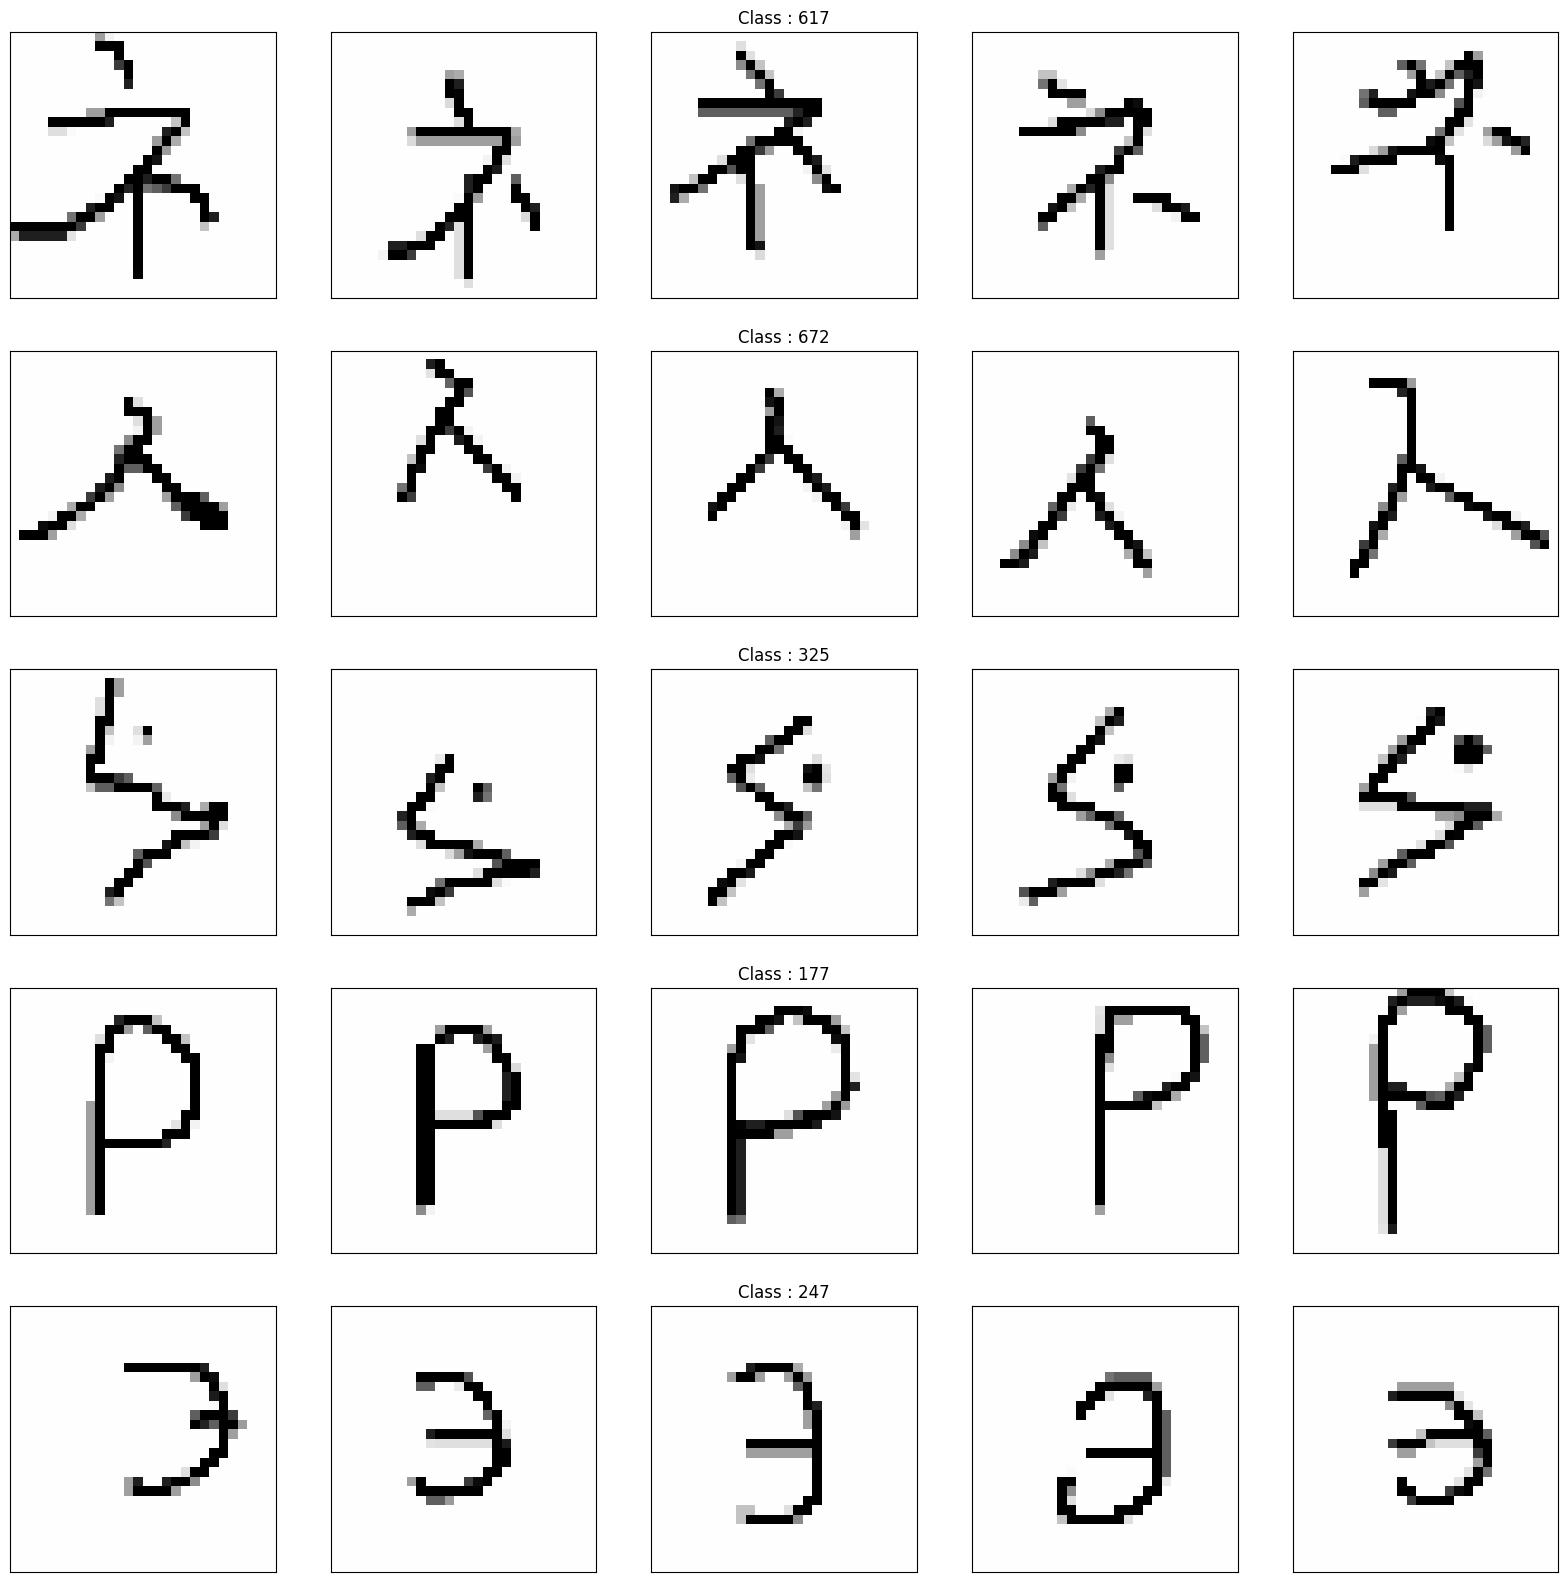

In [5]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
  for b in range(5):
    temp_img = train_dataset.data[sample_keys[a]][b]
    temp_img = np.stack((temp_img[:, :, 0],) * 3, axis=2)
    temp_img *= 255
    temp_img = np.clip(temp_img, 0, 255).astype('uint8')
    if b == 2:
      axarr[a, b].set_title('Class : ' + sample_keys[a])
    axarr[a, b].imshow(temp_img, cmap='gray')
    axarr[a, b].xaxis.set_visible(False)
    axarr[a, b].yaxis.set_visible(False)
plt.show()

##Model construction

In [6]:
def conv_bn(x):
  x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  return layers.ReLU()(x)

inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

##Model training

In [7]:
training = []
testing = []
for meta_iter in range(meta_iters):
  frac_done = meta_iter / meta_iters
  cur_meta_step_size = (1 - frac_done) * meta_step_size
  # Temporary record of model weights
  old_vars = model.get_weights()
  # Taking a sample from the entire collection
  mini_dataset = train_dataset.get_mini_dataset(
      inner_batch_size, inner_iters, train_shots, classes
  )
  for images, labels in mini_dataset:
    with tf.GradientTape() as tape:
      preds = model(images)
      loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  new_vars = model.get_weights()
  # Making SGD for meta step
  for var in range(len(new_vars)):
    new_vars[var] = old_vars[var] + (
        (new_vars[var] - old_vars[var]) * cur_meta_step_size
    )
  # Loading newly-trained scales into the model
  model.set_weights(new_vars)

  if meta_iter % eval_interval == 0:
    accuracies = []
    for dataset in (train_dataset, test_dataset):
      train_set, test_images, test_labels = dataset.get_mini_dataset(
          eval_batch_size, eval_iters, shots, classes, split=True
      )
      old_vars = model.get_weights()
      # Training on samples and getting the resulting supercharges
      for images, labels in train_set:
        with tf.GradientTape() as tape:
          preds = model(images)
          loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
      test_preds = model.predict(test_images)
      test_preds = tf.argmax(test_preds).numpy()
      num_correct = (test_preds == test_labels).sum()

      model.set_weights(old_vars)
      accuracies.append(num_correct / classes)
    training.append(accuracies[0])
    testing.append(accuracies[1])
    if meta_iter % 100 == 0:
      print(
          'batch %d: train=%f test=%f' % (meta_iter, accuracies[0], accuracies[1])
      )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
batch 0: train=0.200000 test=0.200000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

##Visualize the results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


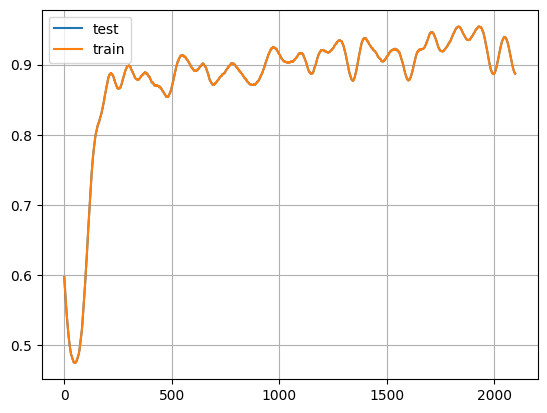

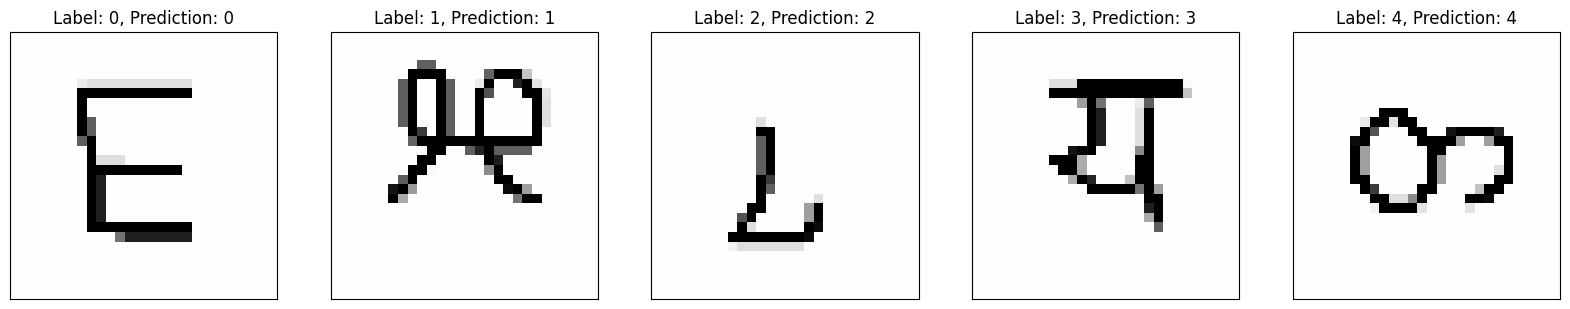

In [8]:
window_length = 100
train_s = np.r_[
    training[window_length - 1:0:-1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    training[window_length - 1:0:-1], training, training[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode='valid')
test_y = np.convolve(w / w.sum(), test_s, mode='valid')

x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(['test', 'train'])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
  with tf.GradientTape() as tape:
    preds = model(images)
    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
  grads = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
  temp_img = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
  temp_img *= 255
  temp_img = np.clip(temp_img, 0, 255).astype('uint8')
  ax.set_title(
      'Label: {}, Prediction: {}'.format(int(test_labels[i]), test_preds[i])
  )
  ax.imshow(temp_img, cmap='gray')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.show()